# Информация о банках

В проекте выполнены функции, позволяющие сохранять и анализировать данные о банках. В частности, с сайта bik-info.ru программа сохраняет общую информацию о банке (Полное название, город, адрес индекс, Кореспондентский счет и др.), с сайта banki.ru программа собирает данные о краткой истории банка и скачивает все отзывы клиентов с их оценками. Далее в проекте отзывы клиентов анализируется с помощью методов машинного обучения и выдается топ слов, которые чаще всего встречаются в положительных отзывах и топ слов из отрицательных отзывов. Таким образом, пользователь с помощью данной программы может быстро получить аггрегированную информацию о банке и понять, что клиентам в нем нравится и что не нравится. Результаты работы выгружаются в Excel файл, который при запуске программы появится в папке, где лежит Jupiter notebook.

In [61]:
# Имортируем нужные библиотеки
import pandas as pd 
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import requests
import json

Будем использовать пример со Сбербанком, однако пользователь может получить информацию и о любом другом банке, вставив в поля ниже имя банка с маленькой буквы на английском и его БИК.

In [62]:
bank_name="sberbank"
#БИК Сбербанка
BIK="044525225"

# Сбор информации о банке

Соберем отзывы о банке и оценки клиентов с помощью **BeautifulSoup** с сайта banki.ru и сохраним их в таблицу в pandas - функция bank_reviews.
Соберем общую информацию о банке с сайта bik-info.ru, используя **API (json)** и сохраним ее в pandas.


In [63]:
#Функция собирает отзывы о банке с сайта banki.ru с помощью beautifulsoup
def bank_reviews(bank_name):
    url="https://www.banki.ru/services/responses/bank/"+bank_name+"/"
    r = requests.get(url)
    page = BeautifulSoup(r.text, "html.parser")
    #number of pages with reviews 
    pages=page.findAll("div", {"class":"margin-top-default"})
    number_pages=int(pages[1].attrs["data-options"].split("totalItems: ")[1].split(";")[0])
    divs = page.findAll("div", class_="responses__item__message markup-inside-small markup-inside-small--bullet")
    scores = page.findAll("div", class_="flexbox flexbox--inline flexbox--row flexbox--gap_xsmall flexbox--align-items_baseline")
    #create blank dataframe in pandas where reviews will be stored
    df = pd.DataFrame(columns=['review number', 'text', 'score'])
    for i in range(0, len(divs)):
        df.at[i, 'text'] = divs[i].get_text(strip=True)
        df.at[i, 'review number'] = i
        metadata=scores[i].findAll('span')
        if len(metadata)>1:
            df.at[i, 'score'] = int(metadata[1].get_text(strip=True))
        #store the number of filled lines
        lines=i
    #we needed to parse the first page separately because we don't know the total number of pages
    #loop which goes from the second page of reviews to the last page and stores the reviews in pandas)
    #если количество отзывов слишком большое, пройдемся по первым 100 страницам с отзывами (получим примерно 2400 отзывов), чтобы код не работал слишком долго
    if number_pages>100:
        number_pages=100
    for j in range(2, number_pages):
        url2=url+"?page="+str(j)
        r = requests.get(url2) 
        page = BeautifulSoup(r.text, "html.parser")
        divs = page.findAll("div", class_="responses__item__message markup-inside-small markup-inside-small--bullet")
        scores = page.findAll("div", class_="flexbox flexbox--inline flexbox--row flexbox--gap_xsmall flexbox--align-items_baseline")
        for i in range(lines+1, lines+len(divs)+1):
            df.at[i, 'text'] = divs[i-lines-1].get_text(strip=True)
            df.at[i, 'review number'] = i
            metadata=scores[i-lines-1].findAll('span')
            if len(metadata)>1:
                df.at[i, 'score'] = int(metadata[1].get_text(strip=True))
        lines=lines+len(divs)
    return df

In [80]:
reviews=bank_reviews("sberbank")

In [81]:
revies2=reviews.copy()

In [82]:
# Функция собирает общую информацтю о банке с помощью json
def bank_info(BIK):
    url="http://www.bik-info.ru/api.html?type=json&bik="+BIK
    params = {'format':'json'}
    g = requests.get(url, params=params)
    q = g.json()
    df = pd.DataFrame(columns=['Информация о банке', 'Значение'])
    df.at[0, 'Информация о банке'] = "Название"
    df.at[0, 'Значение'] = q["name"]
    df.at[1, 'Информация о банке'] = "Город"
    df.at[1, 'Значение'] = q["city"]
    df.at[2, 'Информация о банке'] = "Индекс"
    df.at[2, 'Значение'] = q["index"]
    df.at[3, 'Информация о банке'] = "Адрес"
    df.at[3, 'Значение'] = q["address"]
    df.at[4, 'Информация о банке'] = "БИК"
    df.at[4, 'Значение'] = q["bik"]
    df.at[5, 'Информация о банке'] = "Корреспондентский счет"
    df.at[5, 'Значение'] = q["ks"]
    return df

In [83]:
sber_BIK="044525225"
df=bank_info(sber_BIK)

In [84]:
#функция собирает краткую истоию банка с banki.ru
def bank_info2(bank_name, df):
    url="https://www.banki.ru/banks/bank/"+bank_name+"/"
    r = requests.get(url)
    page = BeautifulSoup(r.text, "html.parser")
    info=page.findAll("div", {"class":"font-size-medium lazy-load"})[0].get_text(strip=True)
    df.at[6, 'Информация о банке'] = "Краткая история"
    df.at[6, 'Значение'] = info
    info2=page.findAll("dl", {"definition-list padding-default"})
    return df

In [85]:
df=bank_info2(bank_name,df)

посчитаем срднюю оценку по отзывам и добавим ее в таблицу с информацией о банке

In [86]:
df.at[7, 'Информация о банке'] = "Средняя оценка"
df.at[7, 'Значение']= reviews["score"].mean()

# Использование машинного обучения

Используем метрику TF-IDF для работы с текстовыми данными. Используем логистическую регрессию для определения того, какие слова влияют на выставление высокой оценки банку или низкой.

## Чистка данных в pandas

Почистим данные для дальнейшей работы с ними.

In [88]:
### FROM: Семинар по машинному обучению №10
#перевод текст отзыва в нижний регистр
reviews['text']=reviews.text.str.lower()
#замена все символы, кроме букв и цифр, на пробелы
review_text=reviews['text'].replace('[^(?u)\\b\\w\\w+\\b]', ' ', regex=True)
#Использование метрики TF-IDF для работы с текстами
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
vectorizer.fit(review_text)
vectorizer.transform(review_text)
#Удаление отзывов, у которых отсутствует оценка
reviews=reviews[reviews['score'].isna()==False]
reviews["score"] = reviews["score"].astype(np.float)

## Классификация отзывов

In [89]:
#Классификация отзывов на положительные и отрицательные
X = vectorizer.transform(reviews['text'])
Y = (reviews["score"].values > 3).astype(int)

In [90]:
random_state = np.random.RandomState(0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=random_state)

#Натренируем модель
lr = LogisticRegression(C=100)
lr.fit(X_train, Y_train)

# Предсказание модели
preds = lr.predict_proba(X_test)[:,1]

## Важность признаков

In [91]:
#Вытащим сами слова из vectorizer
words=vectorizer.get_feature_names()

#Создадим совместный лист слов и весов
f_weights = zip(words, lr.coef_[0])

#отсортируем по весам
f_weights = sorted(f_weights, key=lambda i: i[1])
### END FROM
words = pd.DataFrame(columns=['Топ отрицательных слов из отзывов о банке', 'Топ положительных слов из отзывов о банке'])
for i in range(1,10):
    words.at[i, 'Топ отрицательных слов из отзывов о банке'] = f_weights[-i][0]
    words.at[i, 'Топ положительных слов из отзывов о банке'] = f_weights[i][0]
    

In [92]:
words

,Топ отрицательных слов из отзывов о банке,Топ положительных слов из отзывов о банке
1,спасибо,на
2,очень,ни
3,благодарность,что
4,приятно,нет
5,быстро,10
6,за,рублей
7,хочу,счет
8,всегда,банкомат
9,выразить,отказ


часть машинного обучения доделана не до конца - в идеале нужно использовать nltk библиотку для удаления предлогов, союзов и других служебных частей речи, чтобы в топе показывались только смыловые слова, однако на это не хватило времени.

# Визуализация оценок

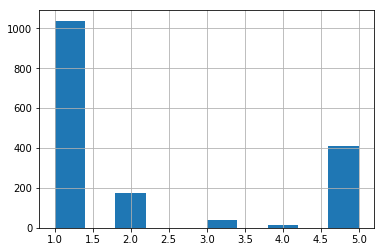

In [93]:
%matplotlib inline
plt.hist(reviews["score"])
plt.grid()

Сохраним информацию о банке и топ положительных и отрицательных слов о нем в этот же эксель файл, что и отзывы.

# Export to excel

Экспортируем информацию о банке  в Excel

In [96]:
writer = pd.ExcelWriter('sberbank.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Info2', index=False)
words.to_excel(writer, sheet_name='Top_words', index=False)
revies2.to_excel(writer, sheet_name='Reviews', index=False)
writer.save()